<a href="https://colab.research.google.com/github/ekshustova/ekshustova/blob/main/CV_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kokarevn. Use `wandb login --relogin` to force relogin


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm


ModuleNotFoundError: ignored

In [ ]:
# You may add any imports you need
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import cv2
import glob
from pandas.core.common import flatten

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-03 12:44:07--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-03 12:44:07--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc626b347e07215c6d783d701c5a.dl.dropboxusercontent.com/cd/0/get/BwD6l6D6Xv1b0887Gh61FqVfKFyKIXdzQ5uc0DrQPUNen6NGqrsYIz_hU4lA4WaiVteT2wM5qx9Y5tttWNfsksRmzT-x9xtsuO0Uj3vg9ipOeGQoG69J6yHhLtN5WiYf6iUbqmycVKoCsE4M0-3urfHXpMSLtl2QKiWSJW2nBMfCag/file?dl=1# [following]
--2022-11-03 12:44:07--  https://uc626b347e07215c6d783d701c5a.dl.dropboxusercontent.com/cd/0/get/BwD6l6D6Xv1b0887Gh61FqVfKFyKIXdzQ5uc0DrQPUNen6NGqrsYIz_hU4lA4WaiVteT2wM5qx9Y5tttW

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
train_data_path = "./dataset/dataset/train"
val_data_path = "./dataset/dataset/val"

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

val_image_paths = []
for data_path in glob.glob(val_data_path + '/*'):
    val_image_paths.append(glob.glob(data_path + '/*'))

val_image_paths = list(flatten(val_image_paths))

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
class MyDataset(Dataset):

    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE брал по следующей ссылке https://albumentations.ai/docs/examples/example/
train_transform = A.Compose([
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.1),
        A.HorizontalFlip(p=0.5),
        A.Sharpen(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.4),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

train_dataset = MyDataset(train_image_paths, transform=train_transform)
val_dataset = MyDataset(val_image_paths, transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

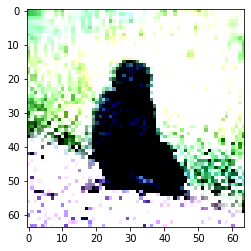

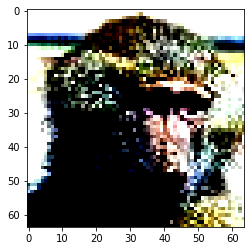

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(YourNet, self).__init__()

        self.model = torchvision.models.densenet121(pretrained=False, num_classes=200)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE

        return self.model(x)

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        self.model = model
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, x):
        # YOUR CODE HERE
        result = self.model(x)

        return result

    def configure_optimizers(self):
        # YOUR CODE HERE
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1)# задаем сам шедулер
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
           'monitor': 'val_loss'
       }

    def training_step(self, train_batch, batch_idx):
        # YOUR CODE HERE
        images, target = train_batch
        loss = self.model(images, target)
        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        # YOUR CODE HERE
        images, target = val_batch
        loss = self.model(images, target)
        self.log('val_loss', loss, prog_bar=True)

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = YourNet().to(device)
module = YourModule(
    model,
    learning_rate = 0.001
)

In [ ]:
seed_everything(123456)
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator='gpu',
                     max_epochs=17,
                     auto_lr_find=True,
                     log_every_n_steps=200,
                     )  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader, ckpt_path='/content/weights for densenet121.ckpt')  # YOUR CODE HERE

In [ ]:
torch.save(model.state_dict(), '/content/savemodel/model.pth') #Сохранил модель, так как гпу часы были близки к концу, vall_loss = 2.18 epoch 15

In [ ]:
model = YourNet().to(device) # Переобозначаю модель
model.load_state_dict(torch.load('/content/savemodel/model.pth')) # И загружаю ранее предобученную мною модель

### Валидация результатов задания

In [ ]:
from sklearn.metrics import accuracy_score
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model._forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print('\n',f'Точность на валидационной выборке {accuracy}', sep='')
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")


100%|██████████| 40/40 [00:04<00:00,  8.94it/s]


Точность на валидационной выборке 0.4744
Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE дополнил предыдущие аугментации аугментациями из torchvision.models.convnext_base recipe, а именно поставил рекомендованный батч, кроп и ресайз
train_transform = A.Compose([
        A.Resize(height=255, width=255),
        A.CenterCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.1),
        A.HorizontalFlip(p=0.5),
        A.Sharpen(p=0.5),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2()
        ])
val_transform = A.Compose([
        A.Resize(height=255, width=255),
        A.CenterCrop(height=224, width=224),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(),
        ])

train_dataset = MyDataset(train_image_paths, transform=train_transform)
val_dataset = MyDataset(val_image_paths, transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
torchvision.models.convnext_base(weights='DEFAULT') # Смотрю архитектуру выходного слоя

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(YourNet, self).__init__()

        self.model = torchvision.models.convnext_base(weights='DEFAULT') # Это инициализирует лучшие известные веса для модели, аргумент pretrained=True устарел
        self.model.classifier = nn.Identity() # Мы удаляем последний предобученный слой классификатора из модели
        self.classifier = nn.Sequential(
              nn.Flatten(start_dim=1, end_dim=-1),
              nn.Linear(in_features=1024, out_features=200, bias=True)) # И создаем другой слой, который будет иметь другой выход

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        with torch.no_grad(): # В форварде саму модель мы будем обучать без градиента
          features = self.model(x)
        preds = self.classifier(features) # И с градиентом только голову модели
        return preds

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss
    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model): #learning rate вроде как уже не нужен, так как он будет задаваться гиперпараметрами импортируемой модели
        super().__init__()
        # YOUR CODE HERE
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), weight_decay=1e-4)

        self.save_hyperparameters()


    def forward(self, x) -> torch.Tensor:

        preds = self.model(x)

        return preds

    def configure_optimizers(self):

        return self.optimizer


    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

NameError: ignored

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = YourNet().to(device)
module = YourModule(model)

In [ ]:
seed_everything(123456)
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator='gpu',
                     max_epochs=2,
                     log_every_n_steps=200)  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 87.8 M
----------------------------------
87.8 M    Trainable params
0         Non-trainable params
87.8 M    Total params
351.078   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
torch.save(model.state_dict(), '/content/savemodel/model2.pth') #Сохранил модель

In [ ]:
model = YourNet().to(device) # Переобозначаю модель
model.load_state_dict(torch.load('/content/savemodel/model2.pth')) # И загружаю ранее предобученную мною модель

<All keys matched successfully>

### Валидация результатов задания

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")


100%|██████████| 157/157 [03:17<00:00,  1.26s/it]


Оценка за это задание составит 9.72 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

***Отчет об экспериментах***

* Задание№1: Сначала пытался написать свою модель, но ей получилось выбить только оценку 7 за 9 часов обучения. После этого я полностью перешел на тестирование готовых непредобученных моделей.
 1. Самый большой импакт внесло **понижение батча**.
 Свою модель я тестировал на батчсайзе 2048, как оказалось в дальнейшем, это чуть ли не худший размер батча для данного задания. На этом же батче я тестировал такие модели как: ShuffleNetV2, MobileNet, MobileNetV2, ResNet18, SqueezeNet, EfficientNetb0, EfficientNetb3, ResNet34. Все эти модели на данном батче были значительно хуже моей самописной, кроме Resnet 18, она был лучше, на ней я смог добить до оценки 7.5 за задание. Потом я прочитал, что на таком батче как у меня модели не тестируют, золотая классика это батчсайз 256 размера и меньше. Я попробал и действительно стало ГОРАЗДО ЛУЧШЕ, ResNet18 дошел до оценки 9.13 за задание, но реальным прорывом стал DenseNet121. Он показывал себя значительно лучше на всех стадиях обучения, ошибка и трейне и на вале падала куда быстрее чем у резнета. Собственно говоря на нем и получилось добиться полученной точности и оценки. К тестированию предыдущих моделей на меньшем батче я не возвращался, так как жалко было времени.
 2. **Аугментации** я просто взял из предоставленной в дз документации. Это также значительно влияло на обучение. В целом, что я заметил в ходе работы, чем меньше агументаций я использовал, тем лучше становился результат. Самые значимые аугментации - простые повороты, они +- ощутимо дали прирост в точности, так как модель меньше переобучалась. Обучение без аугментаций вообще дает ужасный результат. Без аугментаций лосс на трейне падает невероятно быстро, но лосс на валидации только растет. Также пробовал оставлять только ротационные аугментации. В самом начале данный эксперимент показал результаты лучшие чем при том количестве аугментаций, которое у меня есть сейчас, но с ростом количества эпох показатели начинают сравниваться, а потом и вовсе становятся хуже, так что тот набор аугментаций, который я выделил, является наиболее опитмальными.
 3. **Задавать lr самостоятельно** оказывается лучше чем пользоваться **auto_lr_find** только в краткосрочной перспективе, с ростом эпох у меня не получилось получить качество лучше с собственным lr, чем с auto_lr

* Задание№2: Наученный горьким опытом первого задания, второе не составило никаких трудностей. Я уже отлично ориентировался в моделях на тот момент, перешерстил тонны разных документов и знал какую модель для этого задания я хочу использовать и какие аугментации мне нужно применить. Все недостающие аугментации я взял из recipe, которое прилагается к каждой модели на сайте pytorch-a, там же нашел рекомендованный батчсайз и аугментации и их параметры. На базе 5-го семинара не составило труда переписать класс модели и модуля, загнать в тренировочный цикл и получить отличный результат. Модель выбирал по топ accuracy@1 на imagenet, также информация предоставлена на сайте pytorch и по числу параметров, чтобы их было поменьше. Уже с первой эпохи аккураси равен 0.82, что эквивалентно оценке 9.7, с увеличением эпох качество растет, но очень медленно.

